In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing libraries

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from keras import models
# from keras import layers
# from keras import optimizers
# from keras.layers.core import Dense, Dropout, Activation
from PIL import ImageFile
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

## Reading Training and Testing data

In [3]:
data = pd.read_csv('../input/logical-rythm-2k20-sports-image-classification/train_labels.csv',dtype=str)
test = pd.read_csv('../input/logical-rythm-2k20-sports-image-classification/test_images_list.csv',dtype=str)

path = '../input/logical-rythm-2k20-sports-image-classification/train/train/'
num_classes = 22

data.sports.value_counts()

badminton         698
football          611
volleyball        565
ice_hockey        559
baseball          555
tennis            555
boxing            542
formula1          539
gymnastics        531
swimming          531
table_tennis      530
motogp            513
wwe               508
cricket           501
fencing           494
weight_lifting    450
wrestling         432
shooting          417
hockey            405
chess             375
basketball        375
kabaddi           354
Name: sports, dtype: int64

In [4]:
# changing name of images from "./train/0.jpg" to "0.jpg" and doing same with test data_csv 

for index, row in data.iterrows():
    row['image'] = row['image'][8:]

for index, row in test.iterrows():
    row['image'] = row['image'][7:]

## Displaying sample images from dataset

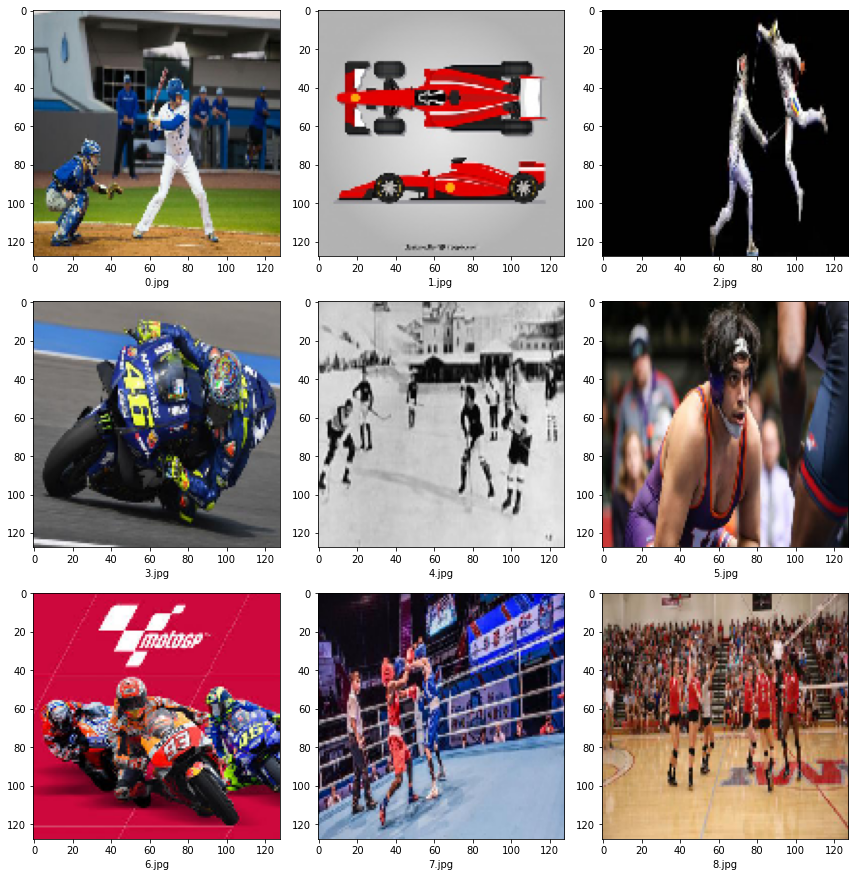

In [5]:
sample = data.head(9)
sample.head()
plt.figure(figsize=(12, 24))
for index, row in sample.iterrows():
    image = row['image']
    sport = row['sports']
    img = load_img(path+image, target_size=(128,128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(image)
plt.tight_layout()
plt.show()

## Using Image Augmentation to highlight important features of data

In [6]:
import imgaug as ia
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Sometimes(0.65,
        iaa.GaussianBlur(sigma=(0, 0.1)) # adding gaussian blur to images for better feature detection
    ),
    iaa.Sometimes(0.75, iaa.Sharpen()),
    iaa.PerspectiveTransform(scale=0.09)
], random_order=True)

def color_generator(batches, seq):
    while True:
        batch_x, batch_y = next(batches)
        _batch_x = seq.augment_images(batch_x)
        yield (_batch_x, batch_y)

## Creating Image data generator to read images from the directory

In [7]:
batch_size=32
image_size = 224

train_datagen = ImageDataGenerator(
    rescale=1./255, # scaling each pixel value in the range of 0-1
    shear_range = 0.25,
    zoom_range = 0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.05)

train_generator = train_datagen.flow_from_dataframe(
        data, 
        "../input/logical-rythm-2k20-sports-image-classification/train/train/", 
        x_col='image',
        y_col='sports',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

# 5% of data is used for validation
validation_generator = train_datagen.flow_from_dataframe(
        data, 
        "../input/logical-rythm-2k20-sports-image-classification/train/train/", 
        x_col='image',
        y_col='sports',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

Found 10488 validated image filenames belonging to 22 classes.
Found 552 validated image filenames belonging to 22 classes.


In [8]:
train_generator = color_generator(train_generator, seq)

# CNN model preparation Using Transfer Learning(InceptionV3)

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet101
from keras.models import Sequential, Model, Input, load_model
from keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

"""Creating a custom callback function to prevent overfitting and reduce learning Time"""
callbacks = [
    EarlyStopping(patience=7, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=False)
]

In [11]:
# creating a base model using InceptionV3 architecture and getting weights from imagenet 
inception = InceptionV3(weights='imagenet', include_top=False,input_shape=(image_size, image_size,3))
print(len(inception.layers))

87916544/87910968 [==============================] - 2s 0us/step
311


In [12]:
max_layers = 200 # we freeze the weights till here and henceforth we start training 

for layer in inception.layers[:max_layers]:
    layer.trainable = False
for layer in inception.layers[max_layers:]:
    layer.trainable = True

In [13]:
# Adding Fully connected layers to the base model and the finally compiling it for predicting 22 classes
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.3)(x)

predictions = Dense(num_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

Total params: 22,074,742
Trainable params: 13,083,862
Non-trainable params: 8,990,880
__________________________________________________________________________________________________


In [14]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=328,
      epochs=60,
      validation_data=validation_generator,callbacks=callbacks)

Epoch 1/60
328/328 [==============================] - ETA: 0s - loss: 1.9162 - acc: 0.5049
Epoch 00001: val_loss improved from inf to 1.35064, saving model to model1.h5
328/328 [==============================] - 201s 614ms/step - loss: 1.9162 - acc: 0.5049 - val_loss: 1.3506 - val_acc: 0.6993
Epoch 2/60
328/328 [==============================] - ETA: 0s - loss: 1.2365 - acc: 0.7018
Epoch 00002: val_loss improved from 1.35064 to 0.80122, saving model to model1.h5
328/328 [==============================] - 181s 551ms/step - loss: 1.2365 - acc: 0.7018 - val_loss: 0.8012 - val_acc: 0.7989
Epoch 3/60
328/328 [==============================] - ETA: 0s - loss: 0.9478 - acc: 0.7712
Epoch 00003: val_loss improved from 0.80122 to 0.63182, saving model to model1.h5
328/328 [==============================] - 180s 550ms/step - loss: 0.9478 - acc: 0.7712 - val_loss: 0.6318 - val_acc: 0.8351
Epoch 4/60
328/328 [==============================] - ETA: 0s - loss: 0.8333 - acc: 0.8032
Epoch 00004: val_lo

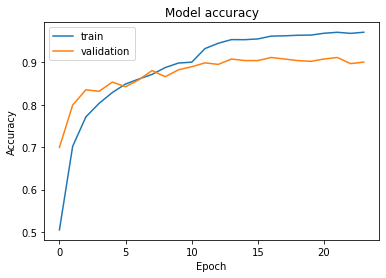

In [15]:
"""Plotting train and validation accuracy"""
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Preparing test data for making prediction

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="../input/logical-rythm-2k20-sports-image-classification/test/test/",
    x_col='image',
    y_col=None,
    target_size=(image_size, image_size),
    class_mode=None,
    shuffle=False,
    batch_size=batch_size
)

Found 2760 validated image filenames.


In [17]:
from tensorflow.keras.models import load_model
"""Loading the best model from the training"""
model = load_model('./model1.h5', compile = True)

## Making prediction on the test data using the best model

In [18]:
predictions = model.predict_generator(test_generator) 

In [19]:
print(predictions)
print()
print(np.argmax(predictions, axis=1))

[[5.94640526e-12 2.69502511e-11 1.78787632e-14 ... 2.56079550e-17
  3.10064077e-19 1.51667800e-16]
 [6.43634072e-13 1.68935410e-09 4.05628656e-12 ... 1.04566522e-10
  2.45709321e-11 6.54896581e-10]
 [2.67333311e-09 9.60870807e-07 9.77197558e-08 ... 4.47373196e-08
  1.49478439e-08 3.71750360e-07]
 ...
 [2.05663028e-13 1.07983733e-09 6.81328366e-13 ... 1.09451935e-11
  4.94207800e-12 2.39158165e-10]
 [5.95478227e-08 7.53413445e-14 1.47457047e-11 ... 1.47105127e-14
  4.04109170e-15 3.58578196e-17]
 [9.99858260e-01 2.11149653e-09 8.90515495e-10 ... 5.10212816e-10
  4.58430433e-10 2.22679514e-11]]

[ 7 13 11 ... 13 17  0]


In [20]:
print(validation_generator.class_indices)

{'badminton': 0, 'baseball': 1, 'basketball': 2, 'boxing': 3, 'chess': 4, 'cricket': 5, 'fencing': 6, 'football': 7, 'formula1': 8, 'gymnastics': 9, 'hockey': 10, 'ice_hockey': 11, 'kabaddi': 12, 'motogp': 13, 'shooting': 14, 'swimming': 15, 'table_tennis': 16, 'tennis': 17, 'volleyball': 18, 'weight_lifting': 19, 'wrestling': 20, 'wwe': 21}


## Creating submission

In [21]:
inv_map = {v: k for k, v in validation_generator.class_indices.items()}
print(inv_map)
submission = pd.DataFrame(data= {'image': test_generator.filenames , 'sports' : np.argmax(predictions, axis=1)}, index=None )
submission = submission.replace(inv_map)

submission['image'] = './test/' + submission['image'].astype(str)
print(submission.head())

{0: 'badminton', 1: 'baseball', 2: 'basketball', 3: 'boxing', 4: 'chess', 5: 'cricket', 6: 'fencing', 7: 'football', 8: 'formula1', 9: 'gymnastics', 10: 'hockey', 11: 'ice_hockey', 12: 'kabaddi', 13: 'motogp', 14: 'shooting', 15: 'swimming', 16: 'table_tennis', 17: 'tennis', 18: 'volleyball', 19: 'weight_lifting', 20: 'wrestling', 21: 'wwe'}
          image      sports
0  ./test/0.jpg    football
1  ./test/1.jpg      motogp
2  ./test/2.jpg  ice_hockey
3  ./test/3.jpg       chess
4  ./test/4.jpg      motogp


In [22]:
filename = 'Sports_image3.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: Sports_image3.csv
